&lt;matplotlib.image.AxesImage at 0x7eff3c2af1f0&gt;

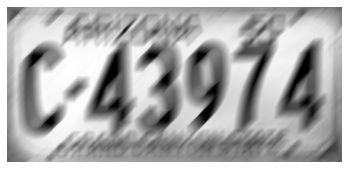

In [1]:
import numpy as np
import cv2 as cv
import matplotlib.pyplot as plt

from numpy import unravel_index
from skimage.feature import canny
from skimage.transform import hough_line
from skimage import restoration, color
from skimage import io

# Approach (from 'Research on the blind restoration algorithm of motion-blurred image'(https://ieeexplore.ieee.org/stamp/stamp.jsp?tp=&arnumber=7867241))
# 1. Estimate motion parameters : angle and length (Assuming motion is linear)
#   1.1. Estimate angle using Hough Transform (Algorithm1from 'Review of Motion Blur Estimation Techniques'(https://pdfs.semanticscholar.org/4039/97ec31d17cbdd02df03622a4797ca135d2ef.pdf) )
#   1.2. Fine-tune motion length
# 2. Contruct PSF function using estimated motion parameters
# 3. Reconstruct image using deconvolution

PSF_KERNEL_SIZE = 65

def gen_psf_kernel(angle, length, kernel_size):
    # Rotate and shift to center using affine transform
    angle = np.deg2rad(angle)
    rotation_m = np.array([[np.cos(angle), -np.sin(angle)], [np.sin(angle), np.cos(angle)]]) # Rotate by angle
    translation_m = np.array([[np.round(kernel_size/2)], [np.round(kernel_size/2)]]) - np.matmul(rotation_m, np.array([[length/2], [0]])) # Shift to center
    tf_mat = np.hstack([rotation_m, translation_m])
    line = np.ones((1, length))
    psf_kernel = cv.warpAffine(line, tf_mat, (kernel_size, kernel_size))

    return psf_kernel

def motion_deblur(img, motion_angle, motion_length):
    psf = gen_psf_kernel(motion_angle, motion_length, PSF_KERNEL_SIZE)
    recon_img, _ = restoration.unsupervised_wiener(img, psf)
    # recon_img = restoration.richardson_lucy(img, psf)
    return recon_img

img = color.rgb2gray(cv.imread('MotionBlur_LicensePlate.png'))
plt.axis('off')
plt.imshow(img, cmap='gray')

Motion angle(degree) : 45.12534818941506


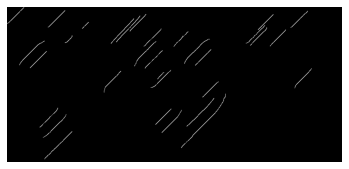

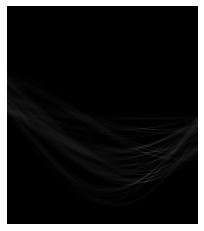

In [2]:
# Estimate motion angle using Hough Transform

# Detect edges
edges = canny(img, low_threshold=0.2, high_threshold=0.4)
plt.axis('off')
plt.imshow(edges, cmap='gray')

# Detect lines from edges
theta = np.linspace(-np.pi / 2, np.pi / 2, 360)
accumulator, angles, d = hough_line(edges, theta)

# Find angle of dominant line
dominant_rho_idx, dominant_theta_idx = unravel_index(accumulator.argmax(), accumulator.shape)
motion_angle = 90. - np.rad2deg(angles[dominant_theta_idx])
plt.figure()
plt.axis('off')
plt.imshow(accumulator, cmap='gray', aspect=1/5)
print(f'Motion angle(degree) : {motion_angle}')

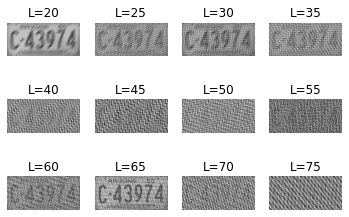

In [3]:
# Find the range of motion length
fig, axes = plt.subplots(3,4)
lengths = list(range(20, 80, 5))

for i, motion_length in enumerate(lengths):
    deblur_image = motion_deblur(img, -motion_angle, motion_length)
    row, col = int(i/4), int(i%4)
    axes[row, col].axis('off')
    axes[row, col].set_title(f'L={motion_length}')
    axes[row, col].imshow(deblur_image, cmap='gray')

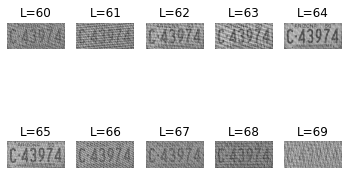

In [4]:
# Narrow down the length
fig, axes = plt.subplots(2,5)
lengths = list(range(60, 70))

for i, motion_length in enumerate(lengths):
    deblur_image = motion_deblur(img, -motion_angle, motion_length)
    row, col = int(i/5), int(i%5)
    axes[row, col].axis('off')
    axes[row, col].set_title(f'L={motion_length}')
    axes[row, col].imshow(deblur_image, cmap='gray')

&lt;matplotlib.image.AxesImage at 0x7efee8d7bd00&gt;

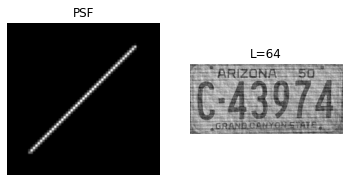

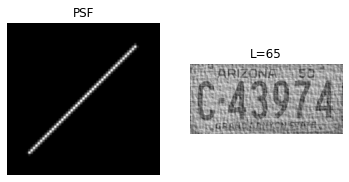

In [5]:
# Compare two best params
plt.figure()
plt.subplot(121)
plt.axis('off')
plt.title('PSF')
plt.imshow(gen_psf_kernel(-motion_angle, 64, PSF_KERNEL_SIZE), cmap='gray')
plt.subplot(122)
plt.axis('off')
plt.title('L=64')
plt.imshow(motion_deblur(img, -motion_angle, 64), cmap='gray')

plt.figure()
plt.subplot(121)
plt.axis('off')
plt.title('PSF')
plt.imshow(gen_psf_kernel(-motion_angle, 65, PSF_KERNEL_SIZE), cmap='gray')
plt.subplot(122)
plt.axis('off')
plt.title('L=65')
plt.imshow(motion_deblur(img, -motion_angle, 65), cmap='gray')


In [6]:
motion_length = 64 # 64 Gives the best result
recon_img = motion_deblur(img, -motion_angle, motion_length)
io.imsave('LicensePlate_Deblur.png', recon_img)

Lossy conversion from float64 to uint8. Range [-0.01182030221207578, 0.024164573061048557]. Convert image to uint8 prior to saving to suppress this warning.
